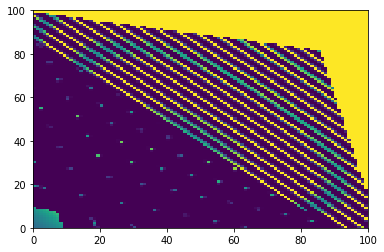

In [9]:
# This notebook will be the auto-tuning routine that will find a single 
# dot window using the subimage classifier
import numpy as np
import tensorflow as tf
import glob
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)



from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

# application logic will be added here
def cnn_model_fn(features,labels,mode):
    '''Model function for CNN'''
    #input layer
    input_layer = tf.cast(tf.reshape(features,[-1,30,30,1]),tf.float32)
    
    conv1 = tf.layers.conv2d(inputs=input_layer,
                            filters=32,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],strides=2)
    
    conv2 = tf.layers.conv2d(inputs=pool1,
                            filters=64,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2)
    
    flat = tf.contrib.layers.flatten(inputs=pool2)
    # dense output layer
    out1 = tf.layers.dense(inputs=flat,units=1024,activation=tf.nn.relu)  
    dropout1 = tf.layers.dropout(
      inputs=out1, rate=0.4, training=mode == learn.ModeKeys.TRAIN)
    
    out = tf.layers.dense(inputs=dropout1, units=4)
    
    loss = None
    train_op = None

    # Calculate loss( for both TRAIN AND EVAL modes)
    if mode != learn.ModeKeys.INFER:
        loss = tf.losses.mean_squared_error(out,labels['prob'])

    # Configure the training op (for TRAIN mode)
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.contrib.framework.get_global_step(),
            learning_rate=1e-3,
            optimizer=tf.train.AdamOptimizer)

    # Generate predictions
    predictions= {
        "prob" : out,
        "states" : tf.argmax(out,axis=1),
    }
    
    # Returna  ModelFnOps object
    return model_fn_lib.ModelFnOps(mode=mode,predictions=predictions,loss=loss, train_op=train_op)
dd_classifier = learn.Estimator(model_fn=cnn_model_fn,model_dir="/Users/ssk4/tensorflow_models/cnn_prob/")


def fitness(param,sub_size,dat,classifier):
    x = int(param[0])
    y = int(param[1])
    sub_image = dat[(x - int(sub_size/2)) :\
                (x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))].flatten()
    state = classifier.predict(x=np.array([sub_image],dtype=np.float32),as_iterable=False)
    fitness = np.linalg.norm(state['prob'] - np.array([0,0,1,0]))
    return fitness

x_0 = 25
y_0 = 25
sub_size = 30
data_folder_path = "/Users/ssk4/Downloads/dataproc/"
files = glob.glob(data_folder_path + "*.npy")
index = np.random.randint(len(files))
dat = np.load(files[index]).item()['current_map']
plt.pcolor(dat,vmax=1e-2)

x_vec = np.arange(15,85,5)
y_vec = np.arange(15,85,5)
xx,yy = np.meshgrid(x_vec,y_vec)
fit = np.zeros((len(x_vec),len(x_vec)))
#for i in range(len(x_vec)):
#    print(i)
#    for j in range(len(y_vec)):
#        x_0 = xx[i,j]
#        y_0 = yy[i,j]
#        fit[i,j] = fitness((x_0,y_0),sub_size,dat,dd_classifier)
#print(fit)



46 16
Initial fitness 1.38846472928
46 16
76 16
76 46
84 74
61 47
61 55
56 41
64 47
60 46
60 49
62 47
60 47
61 48
61 47
61 48
61 47
61 47
61 47
61 47
61 47
61 47
61 47
61 47
61 47
     fun: 0.014396112333843853
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 24
  status: 1
 success: True
       x: array([ 61.11875146,  47.88373084])


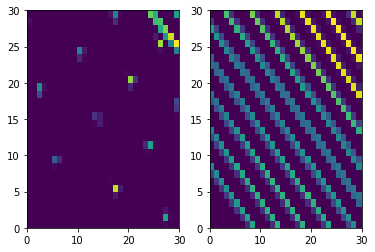

In [295]:
sub_list = []
def fitness(param,sub_size,dat,classifier,sub_list):
    x = int(param[0])
    y = int(param[1])
    sub_image = dat[(x - int(sub_size/2)) :\
                (x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))].flatten()
    state = classifier.predict(x=np.array([sub_image],dtype=np.float32),as_iterable=False)
    fitness = np.linalg.norm(state['prob'] - np.array([0,0,1,0]))
    sub_list += [sub_image]
    print(x,y)
    return fitness


import scipy.optimize
x_0 = 46
y_0 = 16
start_sub_image = dat[(x_0 - int(sub_size/2)) :\
                (x_0 + int(sub_size/2)),(y_0 - int(sub_size/2)):(y_0+int(sub_size/2))]
print("Initial fitness",fitness((x_0,y_0),sub_size,dat,dd_classifier,sub_list))
guess = np.array([x_0,y_0])
cons = [{"type":"ineq","fun":lambda x: x[0] - 16},
        {"type":"ineq","fun":lambda x: x[1] - 16},
        {"type":"ineq","fun":lambda x: 84 - x[0]},
        {"type":"ineq","fun":lambda x: 84 - x[1]}]

res = scipy.optimize.minimize(fitness,x0=guess,args=(sub_size,dat,dd_classifier,sub_list),method="cobyla",
                              options={"rhobeg":30.0,"disp":3},constraints=cons)
#res = scipy.optimize.minimize(fitness,x0=guess,args=(sub_size,dat,dd_classifier),method="SLSQP",
#                              options={"eps":1e5,"disp":3},constraints=cons,callback=lambda x : print(x))
print(res)
x = int(res.x[0])
y = int(res.x[1])
sub_image = dat[(x - int(sub_size/2)) :\
                (x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))]
plt.subplot(1,2,1)
plt.pcolor(start_sub_image)
plt.subplot(1,2,2)
plt.pcolor(sub_image)

basinhopping step 0: f 1.29451
basinhopping step 1: f 1.29213 trial_f 1.29213 accepted 1  lowest_f 1.29213
found new global minimum on step 1 with function value 1.29213
basinhopping step 2: f 1.24172 trial_f 1.24172 accepted 1  lowest_f 1.24172
found new global minimum on step 2 with function value 1.24172
basinhopping step 3: f 1.20774 trial_f 1.20774 accepted 1  lowest_f 1.20774
found new global minimum on step 3 with function value 1.20774
basinhopping step 4: f 1.20774 trial_f 1.22207 accepted 0  lowest_f 1.20774
basinhopping step 5: f 1.20606 trial_f 1.20606 accepted 1  lowest_f 1.20606
found new global minimum on step 5 with function value 1.20606
basinhopping step 6: f 1.20535 trial_f 1.20535 accepted 1  lowest_f 1.20535
found new global minimum on step 6 with function value 1.20535
basinhopping step 7: f 1.20535 trial_f 1.2103 accepted 0  lowest_f 1.20535
basinhopping step 8: f 1.20213 trial_f 1.20213 accepted 1  lowest_f 1.20213
found new global minimum on step 8 with functio

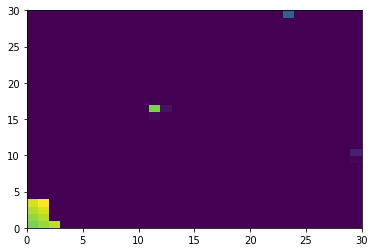

In [155]:
import scipy.optimize
x_0 = 25
y_0 = 25
guess = np.array([x_0,y_0])
res = scipy.optimize.basinhopping(fitness,x0=guess,minimizer_kwargs={"args":(sub_size,dat,dd_classifier)}
                                 ,stepsize=5.0,T=1e-3,niter=25,disp=True)
print(res)
x = int(res.x[0])
y = int(res.x[0])
sub_image = dat[(x - int(sub_size/2)) :\
                (x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))]
plt.pcolor(sub_image)

In [144]:
res.x[0]

55.924734758291116

In [80]:
xx[0,69]

84

In [86]:
x_0 = 15
y_0 = 84
fitness((x_0,y_0),sub_size,dat,dd_classifier)

0.32660072586036004

In [84]:
dat.shape

(100, 100)

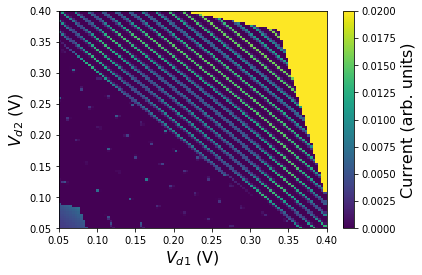

In [272]:
x = np.linspace(50e-3,400e-3,100)
xx,yy = np.meshgrid(x,x)
plt.pcolor(xx,yy,dat,vmax=2*1e-2)
plt.xlabel(r'$V_{d1}$ (V)',fontsize=16)
plt.ylabel(r'$V_{d2}$ (V)',fontsize=16)
cb = plt.colorbar()
cb.set_label('Current (arb. units)',fontsize=16)

plt.savefig("/Users/ssk4/Desktop/tuning.png",dpi=600)

In [203]:
d = np.load(files[index]).item()

{'current_map': array([[  3.41159912e-03,   3.54789945e-03,   3.69340904e-03, ...,
           5.30530736e-02,   5.31537658e-02,   5.32557827e-02],
        [  3.54898198e-03,   3.69274105e-03,   3.84641494e-03, ...,
           5.34979641e-02,   5.36038675e-02,   5.37115949e-02],
        [  3.69551009e-03,   3.84741961e-03,   4.01003820e-03, ...,
           5.39670779e-02,   5.40805507e-02,   5.41973303e-02],
        ..., 
        [  7.02361647e-06,   4.95149805e-05,   5.35554520e-03, ...,
           1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
        [  7.90993747e-05,   6.85903141e-03,   3.15826587e-03, ...,
           1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
        [  8.82308779e-03,   2.21226401e-03,   1.86412715e-05, ...,
           1.00000000e+00,   1.00000000e+00,   1.00000000e+00]]),
 'net_charge_map': array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
      

In [223]:
dd = np.load("/Users/ssk4/old_data/datadump/datadump/double_dot_100_grid_2017-06-26 15:43:41.900013.npy")

In [228]:
dd[1000]

{'input': {'graph_model': (2, 1),
  'physics_model': {'E_scale': 1,
   'K_onsite': 0.02416854416707439,
   'V': array([ 0.07047775,  0.08493721,  0.09996291,  0.11560848,  0.13193581,
           0.14901692,  0.16693611,  0.18579295,  0.2057059 ,  0.22681716,
           0.24929881,  0.27336064,  0.29925982,  0.32731165,  0.35789826,
           0.39146468,  0.42846856,  0.46918316,  0.51306461,  0.55701363,
           0.59219348,  0.60481396,  0.59047183,  0.56069628,  0.52757433,
           0.49655878,  0.46909019,  0.4451366 ,  0.42425095,  0.40592052,
           0.38966374,  0.3750441 ,  0.36165843,  0.34912099,  0.33705862,
           0.3251539 ,  0.31335869,  0.30265873,  0.29704223,  0.30448891,
           0.32855316,  0.36272517,  0.4008015 ,  0.4408436 ,  0.48300074,
           0.52801376,  0.57646092,  0.62767433,  0.67701545,  0.71135735,
           0.71312185,  0.68232658,  0.63658664,  0.58907222,  0.54448272,
           0.50359697,  0.46610015,  0.43197677,  0.40288959,  0.3

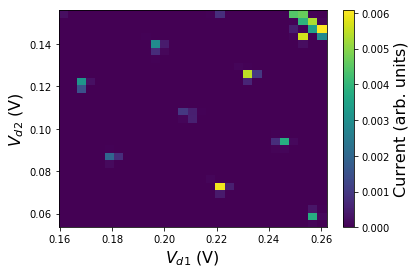

In [279]:
V1_0 = np.linspace(50e-3,400e-3,100)[(x_0 - int(sub_size/2)):(x_0+int(sub_size/2))]
V2_0 = np.linspace(50e-3,400e-3,100)[(y_0 - int(sub_size/2)):(y_0+int(sub_size/2))]
xx1,yy1 = np.meshgrid(V1_0,V2_0)


plt.pcolor(xx1,yy1,start_sub_image)

plt.xlabel(r'$V_{d1}$ (V)',fontsize=16)
plt.ylabel(r'$V_{d2}$ (V)',fontsize=16)
cb = plt.colorbar()
cb.set_label('Current (arb. units)',fontsize=16)
plt.savefig("/Users/ssk4/Desktop/autotuning_start.png",dpi=600)


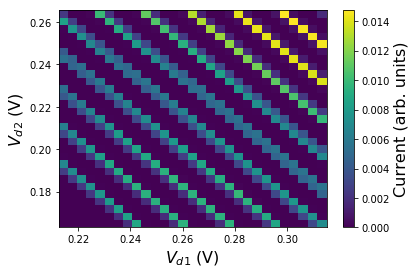

In [280]:
V1 = np.linspace(50e-3,400e-3,100)[(x - int(sub_size/2)):(x+int(sub_size/2))]
V2 = np.linspace(50e-3,400e-3,100)[(y - int(sub_size/2)):(y+int(sub_size/2))]
xx2,yy2 = np.meshgrid(V1,V2)

plt.pcolor(xx2,yy2,sub_image)
plt.xlabel(r'$V_{d1}$ (V)',fontsize=16)
plt.ylabel(r'$V_{d2}$ (V)',fontsize=16)
cb = plt.colorbar()
cb.set_label('Current (arb. units)',fontsize=16)
plt.savefig("/Users/ssk4/Desktop/autotuning_end.png",dpi=600)


In [276]:
x = 76
y = 16
V1 = np.linspace(50e-3,400e-3,100)[(x - int(sub_size/2)):(x+int(sub_size/2))]
V2 = np.linspace(50e-3,400e-3,100)[(y - int(sub_size/2)):(y+int(sub_size/2))]
xx2,yy2 = np.meshgrid(V1,V2)

plt.pcolor(xx2,yy2,sub_image)
plt.xlabel(r'$V_{d1}$ (V)',fontsize=16)
plt.ylabel(r'$V_{d2}$ (V)',fontsize=16)
cb = plt.colorbar()
cb.set_label('Current (arb. units)',fontsize=16)

array([ 0.05      ,  0.05353535,  0.05707071,  0.06060606,  0.06414141,
        0.06767677,  0.07121212,  0.07474747,  0.07828283,  0.08181818,
        0.08535354,  0.08888889,  0.09242424,  0.0959596 ,  0.09949495,
        0.1030303 ,  0.10656566,  0.11010101,  0.11363636,  0.11717172,
        0.12070707,  0.12424242,  0.12777778,  0.13131313,  0.13484848,
        0.13838384,  0.14191919,  0.14545455,  0.1489899 ,  0.15252525,
        0.15606061,  0.15959596,  0.16313131,  0.16666667,  0.17020202,
        0.17373737,  0.17727273,  0.18080808,  0.18434343,  0.18787879,
        0.19141414,  0.19494949,  0.19848485,  0.2020202 ,  0.20555556,
        0.20909091,  0.21262626,  0.21616162,  0.21969697,  0.22323232,
        0.22676768,  0.23030303,  0.23383838,  0.23737374,  0.24090909,
        0.24444444,  0.2479798 ,  0.25151515,  0.25505051,  0.25858586,
        0.26212121,  0.26565657,  0.26919192,  0.27272727,  0.27626263,
        0.27979798,  0.28333333,  0.28686869,  0.29040404,  0.29

ValueError: not enough values to unpack (expected 2, got 1)

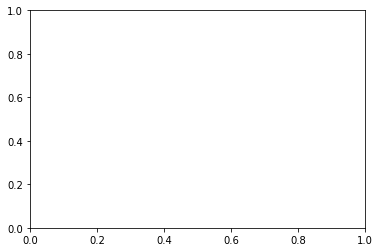

In [296]:
plt.pcolor(sub_list[0])

AttributeError: Unknown property opacity

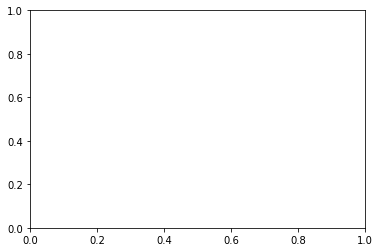

In [315]:
plt.pcolor(sub_list[16].reshape((30,30)),opacity=0.5)

{'prob': array([[ 0.00219238, -0.00727773,  0.86121786,  0.17405985]], dtype=float32), 'states': array([2])}


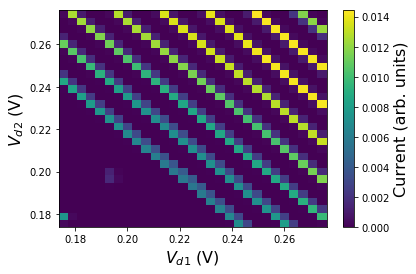

In [58]:
x =50
y= 50
V1 = np.linspace(50e-3,400e-3,100)[(x - int(sub_size/2)):(x+int(sub_size/2))]
V2 = np.linspace(50e-3,400e-3,100)[(y - int(sub_size/2)):(y+int(sub_size/2))]
xx2,yy2 = np.meshgrid(V1,V2)

sub_image = dat[(x - int(sub_size/2)) :\
                (x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))]

plt.pcolor(xx2,yy2,sub_image)
plt.xlabel(r'$V_{d1}$ (V)',fontsize=16)
plt.ylabel(r'$V_{d2}$ (V)',fontsize=16)
cb = plt.colorbar()
cb.set_label('Current (arb. units)',fontsize=16)
state = dd_classifier.predict(x=np.array([sub_image],dtype=np.float32),as_iterable=False)
print(state)
plt.savefig("/Users/ssk4/Desktop/sub3_curr.png",dpi=600)

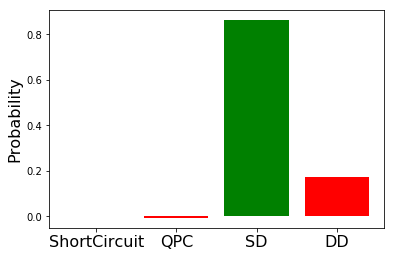

In [59]:
xbins = np.arange(4)
width = 0.35
fig, ax = plt.subplots()
color = ["g" if x > 0.5 else "r" for x in state['prob'][0]]
ax.bar(xbins,state['prob'][0],color=color)
ax.set_xticks(xbins)
ax.set_ylabel('Probability',fontsize=16)
ax.set_xticklabels(('ShortCircuit','QPC','SD','DD'),fontsize=16)
plt.savefig("/Users/ssk4/Desktop/sub3_bar.png",dpi=600)